# Full Example

This notebook contains a full example of training and evaluating a KAN model for a task. The task at hand is learning a multivariate function, namely

$$ f\left(x_1,x_2,x_3,x_4\right) = \exp\left(\sin\left(x_1^2 + x_2^2\right) + \sin\left(x_3^2 + x_4^2\right)\right), $$

which was also learned in one of the original implementation's examples (see [here](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example_2_deep_formula.ipynb)). To do so, we will first generate some training samples, i.e. create an artificial dataset. In order to compare our implementation with the original PyTorch implementation ([pykan](https://github.com/KindXiaoming/pykan/tree/master)) directly, we will be using their `create_dataset` function, using the same sample sizes and seed. This is defined in the present directory's `dataset.py` file and to perform the following tests we (unavoidably) require `torch`.

## Dataset Creation

In [1]:
import torch
import numpy as np

from dataset import create_dataset

We will be using the same formula and sampling used by pykan.

In [2]:
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)

dataset = create_dataset(f, n_var=4, train_num=3000)

Let's now cast these as jnp arrays.

In [3]:
import jax
import jax.numpy as jnp

X_train = jnp.array(dataset['train_input'].numpy())
X_test = jnp.array(dataset['test_input'].numpy())
y_train = jnp.array(dataset['train_label'].numpy())
y_test = jnp.array(dataset['test_label'].numpy())

## Initialization

With the data at hand, we proceed with the initialization of the KAN model.

In [4]:
import optax
from flax import linen as nn

import sys
import os

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN

In [28]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [4, 5, 2, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.02)
variables = model.init(key, jnp.ones([1, 4]))

## Optimizer

For this implementation, `optax` is used to handle optimization and the chosen optimizer is Adam.

In [29]:
# Initialize optimizer from optax
learning_rate = 0.01
optimizer = optax.adam(learning_rate, nesterov=True)
opt_state = optimizer.init(variables['params'])

Note that it does not make much sense to use Adam and then re-initialize it with new parameters every time we perform a grid update. So we define the following function as a workaround to make the transition between grids as smooth as possible.

In [ ]:
TODO

## Loss Function

This is the point where we need to define our loss function. For the predictions we simply use RMSE loss, while for the regularization we can follow the arXiv preprint's direction and use the layer norms and entropy. However, the regularization loss contains several hyper-parameters which require proper tuning. Since the original implementation performs this experiment without regularization, we will simply define the full loss function below as `full_loss_fn` for completeness and instead work with a simple RMSE loss for the present experiment.

In [11]:
def full_loss_fn(params, x, y, state):
    variables = {'params' : params, 'state' : state}
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))

    # Calculate the regularization loss
    loss_reg = 0.0
    for spl_reg in spl_regs:
        # L1 regularization loss
        phis = spl_reg.reshape(-1)
        L1 = jnp.sum(phis)
        # Entropy regularization loss
        frac = phis/L1
        Entropy = -jnp.sum(frac * jnp.log2(frac + 1e-4))
        # Return full regularization loss
        mu_1, mu_2 = 1.0, 2.0
        loss_reg += (mu_1 * L1) + (mu_2 * Entropy)

    # Return total loss
    ell = 0.05
    total_loss = loss_pred + (ell * loss_reg)
    
    return total_loss

In [12]:
def simple_loss_fn(params, x, y, state):
    variables = {'params' : params, 'state' : state}
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))
    
    return loss_pred

## Training

All the pieces of the puzzle are ready, so we may define a `train_step` and start training.

In [13]:
@jax.jit
def train_step(params, opt_state, x, y, state):
    
    loss, grads = jax.value_and_grad(simple_loss_fn)(params, x, y, state)
    
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    new_variables = {'params': params, 'state': state}
    
    return new_variables, opt_state, loss

Of course, we must also define a `grid_upds` dictionary and perform updates periodically between epochs. The first value is always 3, because this corresponds to the first initialization and occurs at the first epoch. Note that the number of epochs used here is much larger than in the original implementation, because we are using a completely different optimizer.

In [30]:
# Training epochs
num_epochs = 1100
# Grid sizes for updates and epochs to occur in. Format = epoch : value
grid_upds = {0 : 3, 300: 5, 600: 10, 900: 20}

train_losses = []
eval_losses = []
for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch+1}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        updated_variables = model.apply(variables, X_train, G_new, method=model.update_grids)
        variables = updated_variables.copy()
        # Re-initialize optimizer when using optax - Adam
        ##opt_state = update_optimizer_state(optimizer, opt_state, variables['params'])
        opt_state = optimizer.init(variables['params'])
        
    # Calculate the loss
    params, state = variables['params'], variables['state']
    variables, opt_state, loss = train_step(params, opt_state, X_train, y_train, state)
    
    train_losses.append(loss)

    # Let's also log evaluation losses, so that we can re-create the training graphs shown in the arXiv pre-print
    eval_preds, _ = model.apply(variables, X_test)
    eval_loss = jnp.sqrt(jnp.mean((eval_preds - y_test) ** 2))

    eval_losses.append(eval_loss)

    if epoch % 10 == 0:
        print(f"Loss = {loss:.4f}")

Epoch 1: Performing grid update
Loss = 4.4964
Loss = 2.6885
Loss = 2.0299
Loss = 1.6673
Loss = 1.2313
Loss = 0.7368
Loss = 0.6694
Loss = 0.5993
Loss = 0.5806
Loss = 0.5691
Loss = 0.5585
Loss = 0.5460
Loss = 0.5299
Loss = 0.5115
Loss = 0.4955
Loss = 0.4849
Loss = 0.4771
Loss = 0.4692
Loss = 0.4608
Loss = 0.4516
Loss = 0.4410
Loss = 0.4286
Loss = 0.4149
Loss = 0.4006
Loss = 0.3867
Loss = 0.3741
Loss = 0.3629
Loss = 0.3529
Loss = 0.3434
Loss = 0.3343
Epoch 301: Performing grid update
Loss = 0.3259
Loss = 0.2929
Loss = 0.2604
Loss = 0.1885
Loss = 0.1133
Loss = 0.0976
Loss = 0.0818
Loss = 0.0743
Loss = 0.0682
Loss = 0.0626
Loss = 0.0568
Loss = 0.0509
Loss = 0.0455
Loss = 0.0409
Loss = 0.0373
Loss = 0.0331
Loss = 0.0328
Loss = 0.0308
Loss = 0.0292
Loss = 0.0280
Loss = 0.0263
Loss = 0.0259
Loss = 0.0250
Loss = 0.0243
Loss = 0.0237
Loss = 0.0230
Loss = 0.0223
Loss = 0.0221
Loss = 0.0216
Loss = 0.0211
Epoch 601: Performing grid update
Loss = 0.0209
Loss = 0.0270
Loss = 0.0178
Loss = 0.0163
Loss

## Results

Let's plot the curves for the training and evaluation losses.

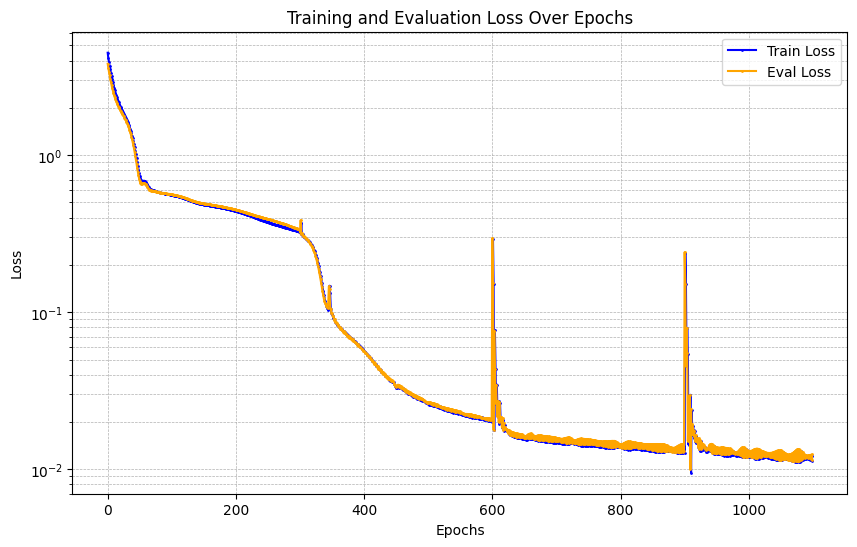

In [31]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss', marker='o', color='blue', markersize=1)
plt.plot(eval_losses, label='Eval Loss', marker='o', color='orange', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines for both major and minor ticks
plt.show()

Let's plot the results and compare them with the ground truth.

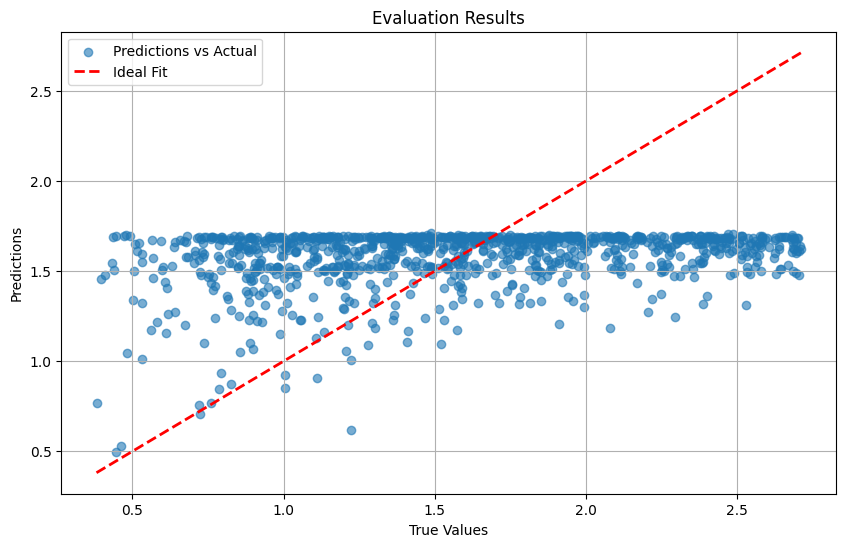

In [16]:
import matplotlib.pyplot as plt

# Plot the evaluation results
plt.figure(figsize=(10, 6))

plt.scatter(y_test, eval_preds, label='Predictions vs Actual', alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Evaluation Results')

plt.legend()
plt.grid(True)

plt.show()